In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

from lib import data
from lib import parameterizations as params
from lib import samplers
from lib import schedules as scheds

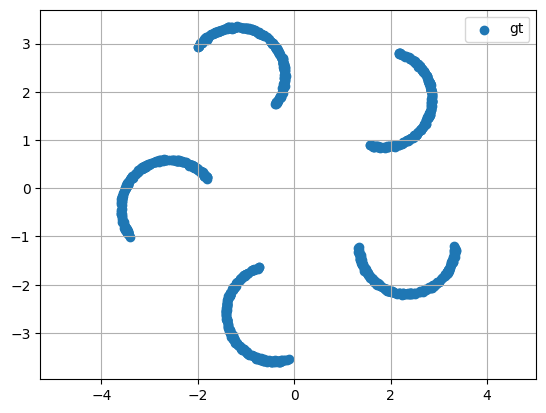

In [3]:
xs = data.half_moons(1000)
xs = data.randn_like(xs) * 0.01 + xs
data.show_2d(xs, label='gt')
plt.legend()

In [4]:
class Model(nn.Module):
    
    def __init__(self, d_in, d_out, *, d_hidden=64, num_layers=5):
        super(Model, self).__init__()
        layers = nn.ModuleList()
        for i in range(num_layers):
            d_in_ = d_in + 2 if i == 0 else d_hidden
            layers.append(nn.Linear(d_in_, d_hidden))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(d_hidden, d_out))
        self.layers = layers

    def forward(self, x, t):
        x = torch.concatenate([x, torch.sin(t), torch.cos(t)], axis=-1)
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:
model = Model(2, 2)
x = torch.randn(5, 2)
t = torch.rand(5, 1)
model(x, t)

param = params.Epsilon(model, scheds.VariancePreserving())
param.epsilon(x, t)
param.x0(x, t)
param.v(x, t)
param.u(x, t)

tensor([[ 1.4101,  2.6220],
        [ 0.5953, -7.3819],
        [-0.7086, -0.7033],
        [-0.0686,  0.8334],
        [ 0.6888, -1.8235]], grad_fn=<SubBackward0>)

In [6]:
# Diffusion Training

class Trainer:

    def __init__(self, xs, max_steps=10_000, sched=None, param=None, sampler=None):
        super(Trainer, self).__init__()
        self.current_step = 0
        self.max_steps = max_steps
        self.xs = torch.from_numpy(xs).float()
        self.sched = sched or scheds.VariancePreserving()
        self.model = Model(d_in=xs.shape[-1], d_hidden=64, d_out=xs.shape[-1])
        self.param = param or params.Epsilon(self.model, self.sched)
        self.sampler = sampler or samplers.DDIM(self.param, self.sched, xs.shape[1:])
        self.optimizer = optim.Adam(self.param.parameters(), lr=1e-3)
        self.lr = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, max_steps)
    
    def step(self, bs=64):
        x = self.sample_batch(bs)
        t = self.sample_time(bs)
        eps = torch.randn(*x.shape)
        z_t = self.alpha(t) * x + self.sigma(t) * eps
        eps_hat = self.param.epsilon(z_t, t)
        weight = self.weight(self.lambda_(t))
        loss = torch.mean(weight * self.squared_error(eps, eps_hat))
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.lr.step()
        self.current_step += 1
        
        return loss

    def sample(self, num_samples=64, num_steps=200):
        return self.sampler.sample(num_samples, num_steps)

    def sample_batch(self, k):
        n = self.xs.shape[0]
        i = torch.randint(n, (k,))
        return self.xs[i]

    def sample_time(self, n):
        return torch.rand(n).reshape((-1, 1))

    def alpha(self, t):
        return self.sched.alpha(t)

    def sigma(self, t):
        return self.sched.sigma(t)

    def weight(self, lambda_):
        return torch.ones_like(lambda_)  # TODO: Update?

    def lambda_(self, t):  # log(signal-to-noise ratio)
        return torch.log(self.alpha(t) ** 2 / self.sigma(t) ** 2)

    def dlambda_dt(self, t):
        t = t.detach().clone().requires_grad_(True)
        lambda_ = self.lambda_(t)
        lambda_.backward(torch.ones_like(lambda_))
        return t.grad

    def squared_error(self, x, x_hat):
        err = torch.square(x - x_hat)
        axes = [i for i in range(x.ndim) if i > 0]
        return torch.mean(err, axis=axes)


tensor([[ 469.0379,  298.5282],
        [-615.4020,   96.5777]], grad_fn=<AddBackward0>)

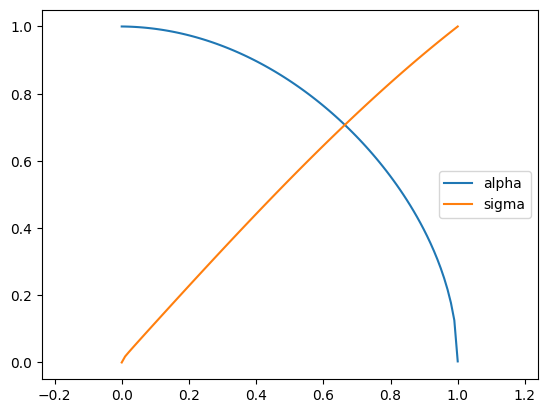

In [7]:
trainer = Trainer(xs, max_steps=50_000)

t = torch.linspace(0.0, 1.0, steps=100)
alpha = trainer.alpha(t)
sigma = trainer.sigma(t)
plt.plot(t, alpha, label='alpha')
plt.plot(t, sigma, label='sigma')
plt.axis('equal')
plt.legend()
# trainer.lambda_(t)
# trainer.dlambda_dt(t)
trainer.step()
trainer.sample(2, 10)

In [8]:
losses = []
with tqdm(range(trainer.current_step, trainer.max_steps), mininterval=0.5) as pbar:
    for i in pbar:
        loss = trainer.step()
        if i % 100 == 0:
            pbar.set_postfix(loss=loss)
            losses.append(torch.mean(loss))
    

100%|██████████████████████████████| 49999/49999 [00:24<00:00, 2058.47it/s, loss=tensor(0.4434, grad_fn=<MeanBackward0>)]


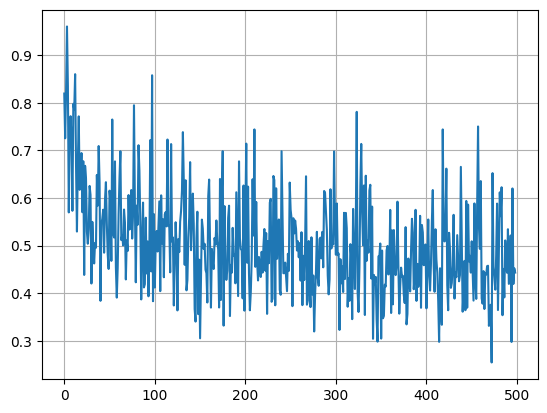

In [9]:
plt.plot(torch.stack(losses).detach().numpy())
plt.grid(True)

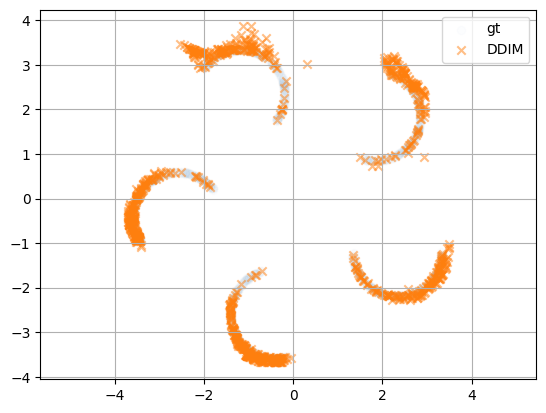

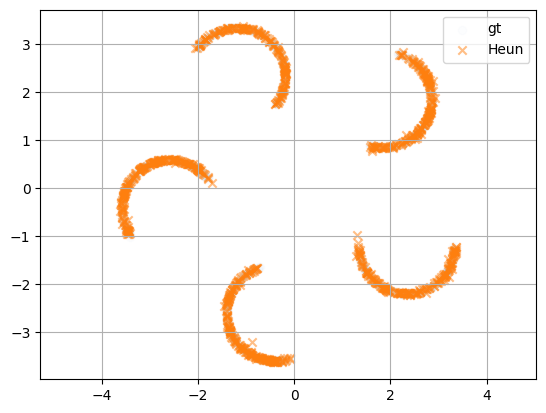

In [32]:
ddim = samplers.DDIM(trainer.param, trainer.sched, trainer.xs.shape[1:])
heun = samplers.Heun(trainer.param, trainer.sched, trainer.xs.shape[1:])
for sampler in [ddim, heun]:
    xs_hat = sampler.sample(1000, 100).detach().numpy()
    plt.figure()
    data.show_2d(xs, label='gt', marker='o', alpha=0.01)
    data.show_2d(xs_hat, label=sampler.__class__.__name__, marker='x', alpha=0.5)
    plt.legend()